### Group Members

**Ojo, Oluwaseun** | **Sholola, Oluwafunmiwo Judah**

### Context of Dataset and Goal Overview

For our dataset, we settled on automotive data from MarketCheck spanning 8 years of inventory in Canada. Each record indicates the most recent online activity for a particular vehicle, obtained via webcrawlers that aggregate info retrieved from a vast number (~65k) of dealer websites. Online activity is not defined, but it is reasonably safe (based on the 'price' attribute provided) to assume that the records indicate sale listings (and not leases, or rentals).

According to the dataset's [Kaggle link](https://www.kaggle.com/datasets/3ea0a6a45dbd4713a8759988845f1a58038036d84515ded58f65a2ff2bd32e00?resource=download), it was last updated a year ago, so we can reasonably expect 2021 to be the upper limit for the year of car manufacture.

This dataset comprises some expected attributes such as the price, make, mileage and manufacturing year of the car. It also includes more specific (and potentially more interesting) attributes such as the fuel type, the engine size, the (corporate) dealer name and site of activity (zip and province).

While our exact goal is not settled upon just yet, as we have not studied the data in-depth enough to hone in on a single phenom, listed below are a few possible phenomenon that are in contention to be studied by us in future iterations:

* correlation of price to the make and year of a vehicle
* correlation of vehicle fuel type to sales (or frequency of sales, more specifically)
* the ideal car (or kind of car) to buy based on the age of vehicles
* the ideal province to buy a used car within Canada taking price and mileage into consideration

That said, let us dive in!


### Exploring the Data...

Prior to importing our dataset, we quickly observe that the total number of records in the dataset and the number of unique VIN values **DO NOT** match. 

The reason for this disparity in the number of records and the VIN's is due to the fact that certain 
cars come up for sale multiple times within the collection window of the dataset (the past year), or they come multiple different dealer sites.

<img src="img\kaggle-id-vin.png" width="600" height="300">






In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pd.options.mode.chained_assignment = None

df = pd.read_csv('ca-dealers-used.csv').sort_index()

# confirming what we observe at a glance on Kaggle
df['vin'].describe()

C:\Users\Fshol\AppData\Local\Temp\ipykernel_10120\3200606419.py:6: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ca-dealers-used.csv').sort_index()


count                393603
unique               226691
top       5LMJJ2JT1KEL20643
freq                     21
Name: vin, dtype: object

### Index selection

Logically, it makes sense to use either the **id** attribute (which is unique) or the **vin** attribute (which, ideally, would be unique in the dataset).

Since some VIN's pop up a few times in the dataset as a result of certain vehicles being traded multiple times, we have to decide:
* if we want to drop duplicate VIN's and simply represent each vehicle once throughout the dataframe, thus making the **vin** attribute unique and possible for use as the **index** of the dataframe; *or*
* if we want to keep multiple instances of a vehicle in the dataframe and utilize **id** as a single index, or **(id, vin)** as a MultiIndex **index** of the dataframe

We decided to drop rows with duplicate VIN's as we do not require multiple instances of a vehicle for the purposes of our analysis. Subsequently, we set **id** attribute as our index.



In [ ]:
# drop rows with duplicate VIN and set 'id' as our index
df_drop = df.copy()
df_drop = df_drop.drop_duplicates('vin')
df_drop = df_drop.reset_index(drop=True).set_index('id')

display(df_drop)

In [ ]:
# getting a basic, high-level overview
display(df_drop.info())

# general description of numerical attributes in dataset
display(df_drop.describe())

### Justification for dropping certain columns

The decision to drop these columns is moreso based on some domain knowledge and logic.

The **stock_no** attribute is unique to each dealer's online inventory categorization system, and is not of a singular format; some are purely numeric in nature, while some are alphanumeric. As such, it is not extremely useful across diverse sources (dealers).

In [ ]:
# display first 20 'stock_no' fields
display(df_drop['stock_no'].head(20))

We decided to drop **trim** attribute  

In [ ]:
display(df_drop.groupby('trim')['make'].describe())
display(sum(df_drop.groupby('trim')['make'].describe()['unique']))

# sum(df_drop.groupby('make')['trim'].describe()['unique'])

The **engine_block** is a low-level attribute that has **3** possible values:
* H-engine type
* I-engine type
* V-engine type

It is not a particularly desirable attribute for our purposes. 

Also, unlike some other attributes such as the manufacturing **year**, which can be decoded from the **VIN** and are uniform/standard across various vehicle manufacturers, the **engine_block** code in the VIN differs across manufacturers (**make**) and even across **models** within the same make. 

As such, it rapidly devolves into an arduous task in trying to retrieve an attribute that we, once again, do not view as useful to our goal(s).

In [ ]:
display(df_drop.groupby('engine_block').count())

df_drop['engine_block'].describe()

The **street** and **zip** attributes are being dropped in favour of 2 other geo-based attributes, **city** and **state**.

#### Proceeding to drop the unwanted columns and reordering our retained columns

In [ ]:
# specify the columns and drop them
col_to_drop = ['stock_no', 'trim', 'engine_block', 'street', 'zip']
df_drop = df_drop.drop(columns=col_to_drop)

# specify an order of columns and order them accordingly
order_of_cols = ['vin', 'make', 'model', 'year', 'age','miles', 'price', 'fuel_type', 'engine_size', 'body_type',  'vehicle_type', 'transmission', 'drivetrain', 'seller_name', 'city', 'state']
df_drop = df_drop[order_of_cols]

# rename state to province (more appropriate to Canada)
df_drop.rename(columns={'state' : 'province'}, inplace=True)

df_drop


### Inclusion of an Additional (Derived) Column

We decided to derive a new column, **age**, based off the manufacturing **year**, which we use to prune off vehicles that fall outside a specific range. It is important to note that this is not a trimming off of outliers, rather we are choosing deal *only* with cars that were manufactured *more recently*.

This attribute might also come in handy in extracting useful features, such as the relationship between the manufacturing **year** of vehicles and the **frequency** (number) of sales.

In [ ]:
## add age col generation here

### Retained Columns and their Descriptions (contextualized)

**id** : unique identifier for each row

**vin** : 17 character long vehicle identification number. This is the value that uniquely identifies each vehicle.

**make** : Make of the vehicle - Decoded from VIN. This is the manufacturer of the vehicle.

**model** : Model of the vehicle - Decoded from VIN. It is the specific model of the vehicle.

**year** : Model year of the vehicle - Decoded from VIN. This is the year the vehicle was manufactured.

**age** : How recently the car was manufactured, using 2022 as a reference point.

**miles** : Number of miles/odometer on the vehicle. The higher the number, the more the vehicle has been driven or used.

**price** : Price of the vehicle. This is the value that we will try to predict.

**fuel_type** : This is the type of fuel the vehicle uses. For example, gasoline, diesel, etc.

**engine_size** : This is the size of the engine in liters.

**body_type** : Body type of the vehicle - Decoded from VIN. This is the type of vehicle. For example, sedan, coupe, SUV, etc.

**vehicle_type** : This is the type of vehicle. For example, car, truck, etc.

**transmission** : Transmission type of the vehicle. The transmission type is either automatic or manual.

**drivetrain** : Drivetrain type of the vehicle. The drivetrain type is either 4WD, FWD, or RWD.

**seller_name** : Name of the seller or dealership

**city** : City of the seller or dealership.

**province** : Province of the seller or dealership




### Filling in Missing Data
Two attributes we decided on, for addressing missing data are:
* **year**; *and*
* **engine_size**

For **year**, it is **not** missing from the original dataset, so we are going to artificially introduce missing values in some rows. The intention (and result) is to repoduce these values by decoding the VIN. It is a standard across all manufacturers that the **10th digit** in the VIN is a *letter* or a *number*, which corresponds to the manufacturing year of the vehicle.

<img src="img\vin-year-dict-mapping.png" width="600" height="300">



In [542]:
 # add filling year

For **engine_size**, about **18%** of values are missing from this attribute in the original dataset. The engine size can be derived from the VIN, but the encoding is unique to each manufacturer and also to the particular model of a vehicle, so using a dictionary would be expensive (memory-wise). As such, we utilize centrality measures, based on categorization fo a related column (**body_type**), to fill missing values.

,count,unique,top,freq
engine_size,,,,
0.6,15,1,Hatchback,15
0.8,4,2,Coupe,2
0.9,93,2,Micro Car,92
1.0,266,6,SUV,96
1.2,313,3,Hatchback,283
...,...,...,...,...
7.4,1,1,Pickup,1
8.0,4,3,Coupe,2
8.1,3,1,Pickup,3


,std,min,mean,max,median,mode
body_type,,,,,,
Car Van,0.246272,1.6,2.282677,2.5,2.40,2.5
Cargo Van,1.167406,2.0,3.827107,6.8,3.70,2.0
Chassis Cab,1.026502,2.1,6.138318,7.3,6.60,6.7
Combi,0.259580,2.0,2.213043,3.0,2.00,2.0
Commercial Wagon,NaN,1.6,1.600000,1.6,1.60,1.6
Convertible,1.469160,0.8,3.566667,8.4,3.50,3.0
Coupe,1.464743,0.8,3.325362,8.4,3.00,2.0
Crossover,0.714108,1.6,2.730769,3.7,2.60,3.5
Cutaway,0.962259,3.2,5.877907,7.3,6.00,6.0


<AxesSubplot:ylabel='body_type'>

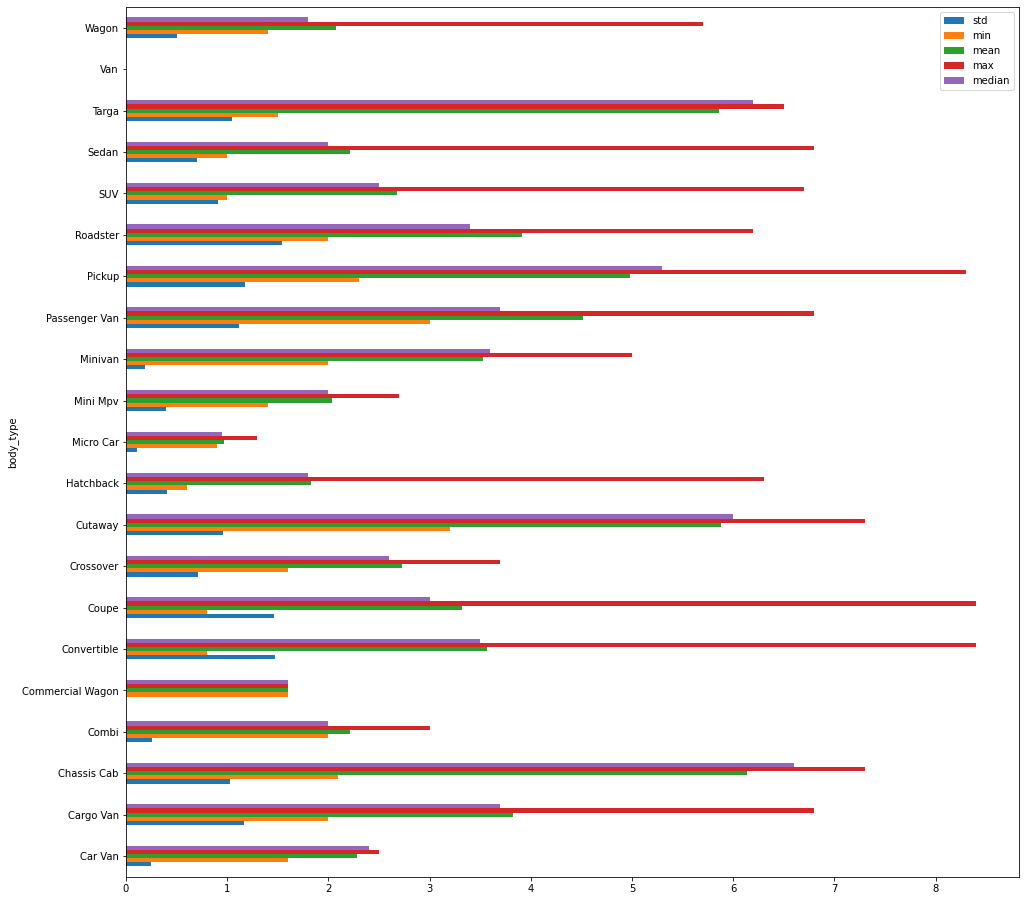

In [25]:
df_temp = df_drop.copy()

# engine_size per body_type category
display(df_temp.groupby('engine_size')['body_type'].describe())


# engine_size stats based on body_type of vehicles
engine_size_stats = df_drop.groupby('body_type')['engine_size'].agg({'mean', 'median', pd.Series.mode, 'std', 'min', 'max'})
engine_size_stats = engine_size_stats[['std', 'min', 'mean', 'max', 'median', 'mode']]
display(engine_size_stats)

fig, axs = plt.subplots(1, 1, figsize=(16,16))
engine_size_stats.plot.barh(ax=axs)

# all vehicles with 'Van' body_type are missing 'engine_size' attribute
# but we don't need to explicitly drop these rows or deal with them
# they'll be replaced with NaN (as their measure of centrality [mean, median, or mode])
# and subsequently removed during the process of dropallna()
# display(df_drop[df_drop['body_type'] == 'Van']['engine_size'].info())


In [33]:
# remove rows with NaN in body_type attr; can't derive a reasonable engine_size heuristic for them
# this is really important; somehow i got the code working without doing this on my desktop
# pushed to github, went to school, set up a clone on my laptop, code didn't work because some rows 
# NaN as body_type; and when trying to fix engine_size, we reference one of the measures of centrality
# of the body_type that that row (vehicle) falls under. well, guess what? you can't reference NaN; and
# because i was so tired/caught up in 'it worked before i came here' (lol, famous programmer last words),
# we ended up just ditching this engine_size fix which i thought was really cool and smart and i worked on
# a one-liner for. came back home and realized this within 5 mins of looking at the code. can you tell that
# i am pained? i am pained. very. much pained. i am pained. this really fudged our delivery up, smh
df_drop.dropna(subset=['body_type'], inplace=True)

# save a record of rows that are currently missing their engine_size (but do not have NaN as body_type, lol)
# this way, we can compare our method of filling (using measures of centrality)
# to some engine_size values derived using some model (if we do go down that route)
engine_size_missing = df_drop[df_drop['engine_size'].isna()]
display(engine_size_missing)   

def fix_engine_size(val) :
    # print(engine_size_stats.loc[val, 'mean'])
    return engine_size_stats.loc[val, 'mean']

# my one-liner beauty, smh. didn't make it into iteration 1 because of my silly oversight/ommission
# but how did it work before? literally sent a pic to Seun of it working. did i delete the essential
# line at some point, fuddddgggggggeeeeeee
df_drop['engine_size'].fillna(df_drop[df_drop['engine_size'].isna()]['body_type'].apply(fix_engine_size), inplace=True)

# should be left with rows (vehicles) with no centrality values for their body_type (NaN for mean of Vans for instance)
display(df_drop[df_drop['engine_size'].isna()])                         


,vin,price,miles,stock_no,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
id,,,,,,,,,,,,,,,,,,,,
d295eb75-3688,1G1RE6E46EU153062,11975.0,145578.0,NaN,2014.0,Chevrolet,Volt,Base,Sedan,Car,FWD,Automatic,Electric / Premium Unleaded,NaN,NaN,auto sur commande rive-nord,3885 Chemin D'oka,Saint-joseph-du-lac,QC,J0N 1M0
a0dd2860-aac1,JTDBVRBD0HA002013,15900.0,49000.0,F002013,2017.0,Toyota,Mirai,Mirai,Sedan,Car,FWD,Automatic,Electric / Hydrogen,NaN,NaN,lp auto,5551 Number 3 Road,Richmond,BC,V6X 2C7
78af3839-df97,JTDBVRBD2GA000388,21998.0,20000.0,UC000388,2016.0,Toyota,Mirai,Mirai,Sedan,Car,FWD,Automatic,Electric / Hydrogen,NaN,NaN,west coast auto group,19900 Lougheed Highway,Pitt Meadows,BC,V3Y 2C7
835fe8e0-1394,JTDBVRBD9GA000436,14000.0,40457.0,LP077,2016.0,Toyota,Mirai,Mirai,Sedan,Car,FWD,Automatic,Electric / Hydrogen,NaN,NaN,rocky mountain dodge chrysler jeep ram,4415 42 Avenue,Rocky Mountain House,AB,T4T 1B6
4b77942b-0ce6,JTDBVRBD9GA000582,18700.0,36396.0,K5294,2016.0,Toyota,Mirai,Mirai,Sedan,Car,FWD,Automatic,Electric / Hydrogen,NaN,NaN,i autohaus sales & leasing,10740 Cambie Road,Richmond,BC,V6X 1K8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98d52f09-3378,2T2BK1BA3DC170035,NaN,59202.0,LEX-170035,2013.0,Lexus,RX,350,SUV,Truck,4WD,Automatic,Premium Unleaded,NaN,NaN,envision auto sales,7500 6 Street Southeast,Calgary,AB,T2H 2W5
caec39a0-c733,WDDGJ7HB7DF999686,37950.0,83849.0,RP-BFRBFJR,2013.0,Mercedes-Benz,C-Class,C63 AMG®,Coupe,Car,RWD,Automatic,Premium Unleaded,NaN,NaN,automobiles ral parent inc,2799 Avenue De Vitr,Qubec,QC,G1J 5G1
f8c8f411-8baf,WDDPK6GA2HF135960,41800.0,6621.0,20210303,2017.0,Mercedes-Benz,SLC Roadster,AMG® SLC43,Roadster,Car,RWD,Automatic,Premium Unleaded,NaN,NaN,ed autos,1275 Rue Notre Dame Nord,Sainte-marie,QC,G6E 2L4


,vin,price,miles,stock_no,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
id,,,,,,,,,,,,,,,,,,,,
20a86f71-7f1c,1FDRE14L7WHB32892,9995.0,190001.0,1115,1998.0,Ford,NaN,Cargo,Van,NaN,RWD,Automatic,NaN,NaN,NaN,tiger auto sales ltd.,2275 Dundas St. East,Unit A,ON,N5V 1R4
669d296d-84e0,1FDWE35F43HA76333,14995.0,189628.0,24348,2003.0,Ford,cube,Diesel,Van,NaN,RWD,Automatic,NaN,NaN,NaN,sk automarket sales ltd,19833 Fraser Highway,Langley City,BC,V3A 4E1
21266f35-9ffb,1FDWE3FP0ADA35645,18995.0,225126.0,24329,2010.0,Ford,Truck,Diesel,Van,NaN,RWD,Automatic,NaN,NaN,NaN,sk automarket sales ltd,19833 Fraser Highway,Langley City,BC,V3A 4E1
afc2f58b-c74e,1FDXE45P07DA07851,13995.0,NaN,17_435,2007.0,Ford,cube,Diesel,Van,NaN,RWD,Automatic,NaN,NaN,NaN,by pass auto sales,27441 Fraser Highway,Aldergrove,BC,V4W 3P9
34a3df26-c6ab,1FDXE4FSXCDA91898,17900.0,91555.0,1701,2012.0,Ford,cube,VAN,Van,NaN,RWD,Automatic,NaN,NaN,NaN,ace automotive,113 Leith Street,Thunder Bay,ON,P7C 1M7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4b56a435-81c8,NM0LS7V20L1447255,32985.0,4645.0,6096119,2020.0,Ford,Transit,XL,Van,NaN,FWD,Automatic,NaN,NaN,NaN,jim pattison lease,1235 73 Avenue Southeast,Calgary,AB,T2H 2X1
1e526678-fd69,NM0LS7V21L1447202,32985.0,8001.0,6096120,2020.0,Ford,Transit,XL,Van,NaN,FWD,Automatic,NaN,NaN,NaN,jim pattison lease,1235 73 Avenue Southeast,Calgary,AB,T2H 2X1
5c3c0107-d7e3,NM0LS7V23L1447203,32985.0,6663.0,6096121,2020.0,Ford,Transit,XL,Van,NaN,FWD,Automatic,NaN,NaN,NaN,jim pattison lease,1235 73 Avenue Southeast,Calgary,AB,T2H 2X1


### Handling Outliers
For outliers, we decided to inspect all our numerical attributes, besides **year** and **age**:
* **price**
* **miles**
* **engine_size**

Let's get a preview of our outliers.


In [ ]:
def plot_box(df, columns):
    fig, axs = plt.subplots(len(columns),1,figsize=(16,18))
    i = 0
    for c in columns:
        df[c].plot.box(ax=axs[i])
        i+=1

col_to_plot = ['price', 'miles', 'engine_size']
plot_box(df_drop, col_to_plot)

### Final Cleanup

Finally, we drop rows missing values from certain columns:
* **vin** : fundamental attribute, cannot be retrieved from others
* **miles** : cannot be retrieved from any other columns
* **model** : is obfuscated in VIN (not a 1-to-1 mapping) since it varies across manufacturers (makes)
* **body_type** : is also obfuscated in VIN (unique to each make); if missing for a particular model of a make, cannot be retrieved from other models
* **city** : even if seller_name is available, if city is missing, it is missing in all instances of seller_name (available or also missing)  
* **province** : same reason as city


In [34]:
# get a preview of the state of the dataset prior to dropping any rows
print(f'State of the Dataset before dropping any rows...')
display(df_drop.info())

# we drop rows missing values from certain columns
df_drop.dropna(inplace=True)

# preview after dropping some rows based on above conditions
print(f'State of the Dataset after dropping some rows...')
display(df_drop.info())

State of the Dataset before dropping any rows...
<class 'pandas.core.frame.DataFrame'>
Index: 206027 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           206027 non-null  object 
 1   price         185353 non-null  float64
 2   miles         194317 non-null  float64
 3   stock_no      191676 non-null  object 
 4   year          206026 non-null  float64
 5   make          206027 non-null  object 
 6   model         205841 non-null  object 
 7   trim          184363 non-null  object 
 8   body_type     206027 non-null  object 
 9   vehicle_type  203618 non-null  object 
 10  drivetrain    183793 non-null  object 
 11  transmission  183851 non-null  object 
 12  fuel_type     181418 non-null  object 
 13  engine_size   205871 non-null  float64
 14  engine_block  180121 non-null  object 
 15  seller_name   204955 non-null  object 
 16  street        202483 non-null

None

State of the Dataset after dropping some rows...
<class 'pandas.core.frame.DataFrame'>
Index: 145701 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           145701 non-null  object 
 1   price         145701 non-null  float64
 2   miles         145701 non-null  float64
 3   stock_no      145701 non-null  object 
 4   year          145701 non-null  float64
 5   make          145701 non-null  object 
 6   model         145701 non-null  object 
 7   trim          145701 non-null  object 
 8   body_type     145701 non-null  object 
 9   vehicle_type  145701 non-null  object 
 10  drivetrain    145701 non-null  object 
 11  transmission  145701 non-null  object 
 12  fuel_type     145701 non-null  object 
 13  engine_size   145701 non-null  float64
 14  engine_block  145701 non-null  object 
 15  seller_name   145701 non-null  object 
 16  street        145701 non-null

None

### Sub-sampling to create working dataset

Once we have dropped duplicate records, filled in missing data and taken care of outliers, it's finally time to select a sub-sample of our still dirty, but *slightly* cleaned, dataset.

For this, we created a random sampler. Given the size of our initial dataset, and the size of the desired sample, it creates bins of roughly same sizes and randomly selects indices from each of these bins. These indices correspond to the indices of rows we will select from our main dataset, which we then proceed to select.

In [ ]:
# generates and returns a random sample of indices [0...n-1] of length, size_sub_df
def random_sampler(size_initial_df,  size_sub_df):
    bin_size = round(size_initial_df/size_sub_df)
    sample_indices = []
    low = 0
    high = 1

    for i in range(0, size_sub_df+1):
        sample_indices.append(np.random.randint((low*bin_size), (high*bin_size)))
        low+=1
        high+=1

    return sample_indices

# generate a list of 1500 random indices between 0 and n-1; n=len(df)
sample_indices = random_sampler(len(df_drop), 1500)
# display(sample_indices)

# use generated indices to sample initial dataframe and create and subset
df_sub = df_drop.iloc[sample_indices, :].copy()
display(df_sub)

### Data Presentation

Below are a few plots highlighting certain aspects of our dataset.

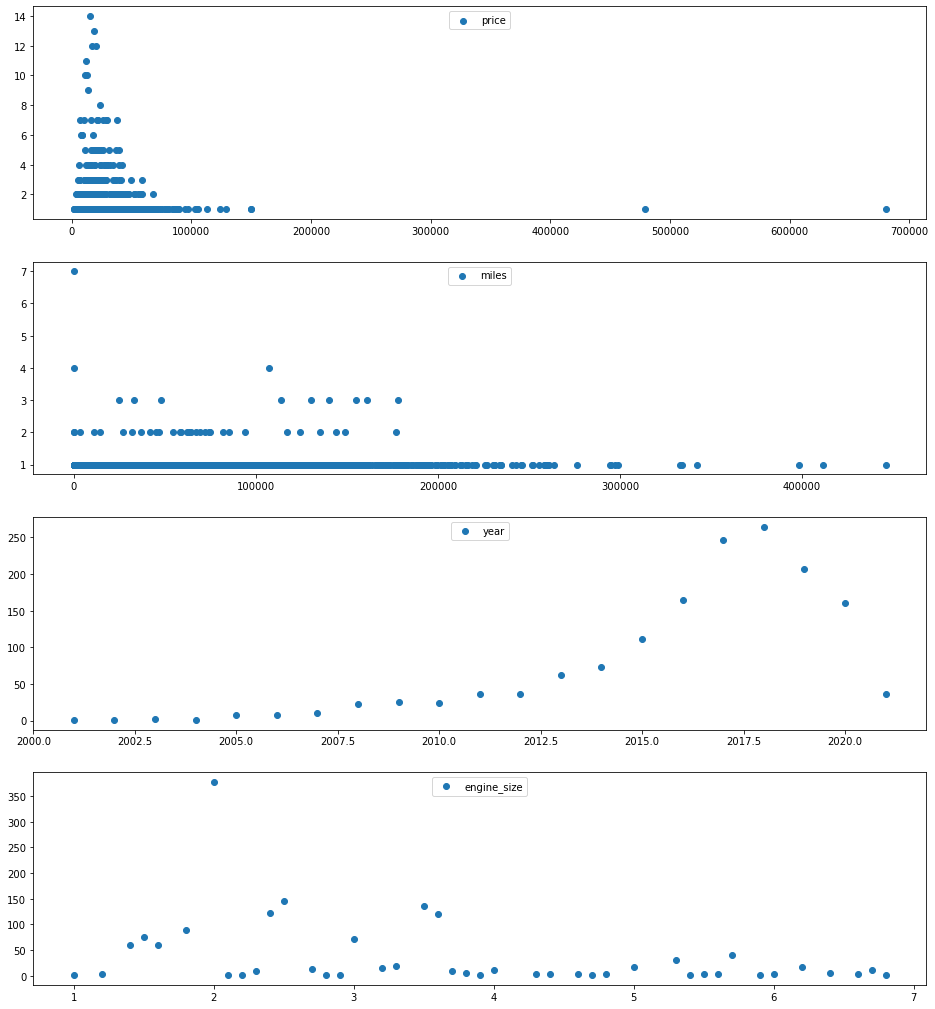

In [37]:
# because our data is not temporal, nor is it reasonable to plot against our index ('id'),
# the natural progression is to plot the 

# plots non-normalized distribution
def plot_all_series(df, columns):
    fig, axs = plt.subplots(len(columns),1,figsize=(16,18))
    axs = axs.flatten()
    i = 0
    for c in columns:
        temp_ser = df.groupby(by=[c]).size()
        axs[i].scatter(x=temp_ser.index, y=temp_ser, label=columns[i])
        axs[i].legend(loc='upper center')
        i+=1

col_to_plot = ['price', 'miles', 'year', 'engine_size']
plot_all_series(df_sub, col_to_plot)

So instead, we plot normalized probability density functions of our numerical attributes. We also utilize histograms as they better describe the congregation of certain values.

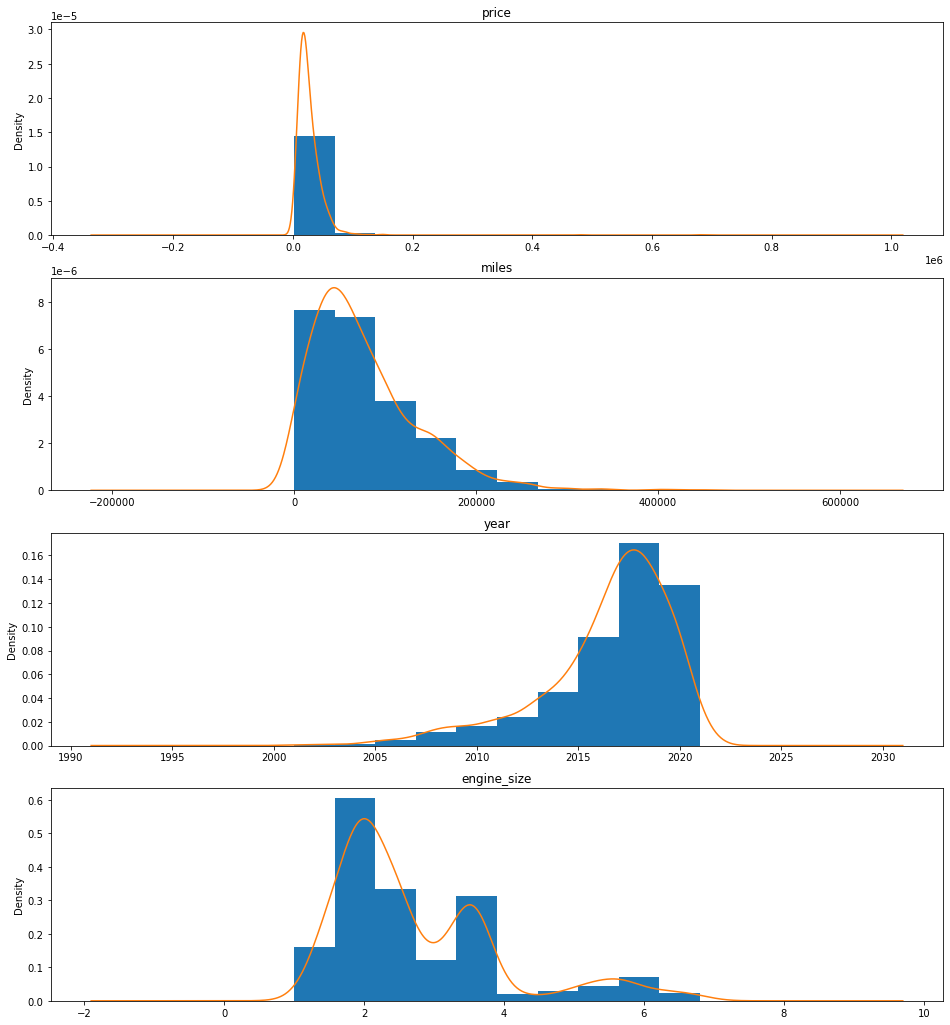

In [38]:
def plot_histograms_density(df, columns):
    fig, axs = plt.subplots(len(columns),1,figsize=(16,18))
    i = 0
    for c in columns:
        df[c].hist(ax=axs[i], density=True)
        df[c].plot.density(ax=axs[i], title=c)
        i+=1

plot_histograms_density(df_sub, col_to_plot)